In [1]:
!pip install xhistogram==0.3.0
!pip install xrft==0.4.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32841")
client

<Client: 'tcp://127.0.0.1:32841' processes=8 threads=64, memory=235.96 GiB>

In [12]:
client.restart()

<Client: 'tcp://127.0.0.1:34777' processes=7 threads=56, memory=206.47 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
# plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

# Load data

In [6]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask()
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask()

In [7]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False).to_dask()
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False).to_dask()
hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()

In [8]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
    
gigatl01w = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma').to_dask())
gigatl01s = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='aso').to_dask())

In [9]:
fesom01w = cat.FESOM(datatype='surf', season='fma').to_dask()
fesom01s = cat.FESOM(datatype='surf', season='aso').to_dask()

In [10]:
orca01w = cat.ORCA36(region='1', datatype='surface_hourly', season='fma').to_dask()
orca01s = cat.ORCA36(region='1', datatype='surface_hourly', season='aso').to_dask()
orca01_grid = cat.ORCA36(region='1', datatype='grid',grid='meshmask').to_dask()

In [6]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [12]:
istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)

llc01w = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                           iters=iters[::12],
                           type='latlon').sel(
#                                               time=slice('2012-02-01','2012-04-30'),
                                              j=slice(9555,10198),j_g=slice(9555,10198),
                                              i=slice(15355,15845),i_g=slice(15355,15845),
                                             ).chunk({'j':200,'j_g':200,
                                                      'i':200,'i_g':200}).isel(k=0)
llc01w

<xarray.Dataset>
Dimensions:  (face: 13, i: 491, i_g: 491, j: 644, j_g: 644, k_l: 1, k_p1: 2, k_u: 1, time: 180)
Coordinates: (12/41)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 15355 15356 15357 15358 15359 ... 15842 15843 15844 15845
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
    k        int64 0
    ...       ...
    XG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>

In [12]:
llc01s = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                           type='latlon').sel(time=slice('2011-08-01','2011-10-31'),
                                              j=slice(4778,5098),j_g=slice(4778,5098),
                                              i=slice(7679,7920),i_g=slice(7679,7920)
                                             ).chunk({'j':100,'j_g':100,
                                                      'i':100,'i_g':100})
llc01s

<xarray.Dataset>
Dimensions:  (face: 13, i: 242, i_g: 242, j: 321, j_g: 321, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 1176)
Coordinates: (12/41)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 7679 7680 7681 7682 7683 ... 7916 7917 7918 7919 7920
  * i_g      (i_g) int64 7679 7680 7681 7682 7683 ... 7916 7917 7918 7919 7920
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * k        (k) int64 0
    ...       ...
    XG       (j_g, i_g) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, k, j, i_g) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    V        (time, k, j_g, i) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>

In [15]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llc01w, periodic=[],
               coords={
#                    'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [9]:
llcfC = xr.apply_ufunc(gsw.f,llc01w.YC,dask='parallelized')
llcfG = xr.apply_ufunc(gsw.f,llc01w.YG,dask='parallelized')
llcfG

<xarray.DataArray 'YG' (j_g: 644, i_g: 491)>
dask.array<transpose, shape=(644, 491), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
    rAz      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>

In [15]:
fio01w = cat["FIO-COM32"](region='1', datatype='surface_hourly', season='fma').to_dask()
fio01s = cat["FIO-COM32"](region='1', datatype='surface_hourly', season='aso').to_dask()
fio01w

<xarray.Dataset>
Dimensions:       (time: 2136, xt_ocean: 320, xu_ocean: 321, yt_ocean: 320, yu_ocean: 321)
Coordinates:
  * time          (time) datetime64[ns] 2018-02-01T13:00:00 ... 2018-05-01T12...
  * xt_ocean      (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.05 -68.02
  * xu_ocean      (xu_ocean) float64 -78.0 -77.97 -77.94 ... -68.06 -68.03 -68.0
  * yt_ocean      (yt_ocean) float64 30.02 30.05 30.08 ... 39.92 39.95 39.98
  * yu_ocean      (yu_ocean) float64 30.0 30.03 30.06 30.09 ... 39.94 39.97 40.0
Data variables:
    eta_t         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    surface_salt  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    usurf         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(275, 321, 321), meta=np.ndarray>
    vsurf         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(275, 321, 321), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [16]:
gridfio = Grid(fio01w, periodic=[],
               coords={
                       'Y':{'center':'yu_ocean','left':'yt_ocean'},
                       'X':{'center':'xu_ocean','left':'xt_ocean'}}
              )
gridfio

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   yu_ocean --> left
  * left     yt_ocean --> center
X Axis (not periodic, boundary=None):
  * center   xu_ocean --> left
  * left     xt_ocean --> center

# Vorticity and strain

In [17]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def nemo_vort(u, v, e1f, e2f, e2v, e1u):
    return (
        diff(v * e2v, 1, axis=-1)
        - diff(u * e1u, 1, axis=-2)
    ) / (e1f  * e2f)

def nemo_div(u, v, e1t, e2t, e1v, e2u):
    return (
        diff(v * e1v, 1, axis=-2)
        + diff(u * e2u, 1, axis=-1)
    ) / (e1t  * e2t)

def nemo_str(u, v, e1t, e2t, e2u, e1v, e1f, e2f, e1u, e2v):
    str1 = (diff(u * e2u, 1, axis=-1)
            - diff(v * e1v, 1, axis=-2)
           ) / (e1t  * e2t)
    str2 = (diff(u * e1u, 1, axis=-2)
            + diff(v * e2v, 1, axis=-1)
           ) / (e1f  * e2f)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

def t_to_f(da):
    return (.25*(da 
                + np.roll(da,1,-1) 
                + np.roll(da,1,-2)
                + np.roll(np.roll(da,1,-1),1,-2)
               )
    )

In [18]:
enatlf = xr.apply_ufunc(gsw.f, enatl01w.lat, dask='parallelized')

vorenatlw = xr.apply_ufunc(
    nemo_vort,
    enatl01w.sozocrtx[::12], 
    enatl01w.somecrty[::12], 
    enatl01w.e1f, enatl01w.e2f,
    enatl01w.e2v, enatl01w.e1u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divenatlw = xr.apply_ufunc(
    nemo_div,
    enatl01w.sozocrtx[::12], 
    enatl01w.somecrty[::12], 
    enatl01w.e1t, enatl01w.e2t,
    enatl01w.e1v, enatl01w.e2u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatlw = xr.apply_ufunc(
    nemo_str,
    enatl01w.sozocrtx[::12], 
    enatl01w.somecrty[::12], 
    enatl01w.e1t, enatl01w.e2t,
    enatl01w.e2u, enatl01w.e1v,
    enatl01w.e1f, enatl01w.e2f,
    enatl01w.e1u, enatl01w.e2v,
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatlw

<xarray.DataArray 'strain' (time_counter: 178, y: 763, x: 611)>
dask.array<transpose, shape=(178, 763, 611), dtype=float32, chunksize=(6, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
Dimensions without coordinates: y, x

In [19]:
vorenatls = xr.apply_ufunc(
    nemo_vort,
    enatl01s.sozocrtx[::12], 
    enatl01s.somecrty[::12], 
    enatl01s.e1f, enatl01s.e2f,
    enatl01s.e2v, enatl01s.e1u,
    input_core_dims = 6 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divenatls = xr.apply_ufunc(
    nemo_div,
    enatl01s.sozocrtx[::12], 
    enatl01s.somecrty[::12], 
    enatl01s.e1t, enatl01s.e2t,
    enatl01s.e1v, enatl01s.e2u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatls = xr.apply_ufunc(
    nemo_str,
    enatl01s.sozocrtx[::12], 
    enatl01s.somecrty[::12], 
    enatl01s.e1t, enatl01s.e2t,
    enatl01s.e2u, enatl01s.e1v,
    enatl01s.e1f, enatl01s.e2f,
    enatl01s.e1u, enatl01s.e2v,
    input_core_dims = 10 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
divenatls

<xarray.DataArray 'vort' (time_counter: 184, y: 763, x: 611)>
dask.array<transpose, shape=(184, 763, 611), dtype=float32, chunksize=(6, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...
Dimensions without coordinates: y, x

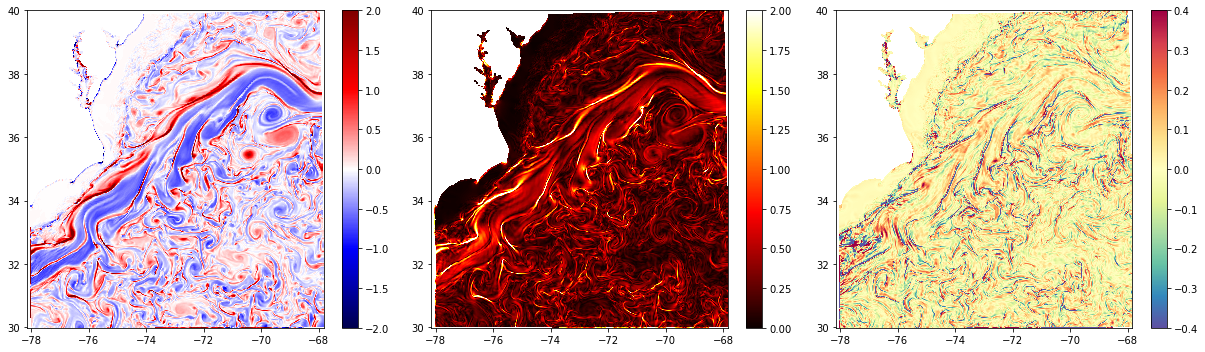

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(enatl01w.lon, enatl01w.lat, strenatlw.isel(time_counter=0)/enatlf, 
                     cmap='hot', vmin=0, vmax=2, rasterized=True)
im3 = ax3.pcolormesh(enatl01w.lon, enatl01w.lat, divenatlw.isel(time_counter=0)/enatlf, 
                     cmap='Spectral_r', vmax=.4, vmin=-.4, rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

/tmp/ipykernel_994/3679698212.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(enatl01w.lon, enatl01w.lat, np.ma.masked_invalid(vorenatlw.isel(time_counter=0)).mask,
/tmp/ipykernel_994/3679698212.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0)/enatlf,


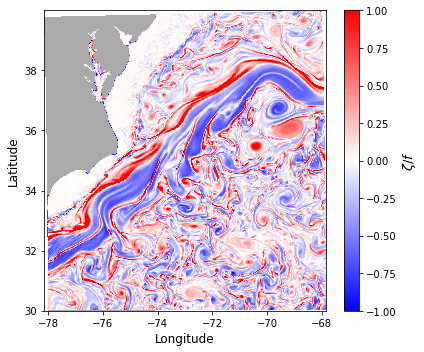

In [23]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(enatl01w.lon, enatl01w.lat, np.ma.masked_invalid(vorenatlw.isel(time_counter=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-eNATL60_01.pdf')

In [24]:
orcaf = xr.apply_ufunc(gsw.f, orca01w.nav_lat, dask='parallelized')

vororcaw = xr.apply_ufunc(
    nemo_vort,
    orca01w.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01w.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1f.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e2v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e1u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01w.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divorcaw = xr.apply_ufunc(
    nemo_div,
    orca01w.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01w.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01w.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strorcaw = xr.apply_ufunc(
    nemo_str,
    orca01w.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01w.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e2u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e1v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01w.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strorcaw

<xarray.DataArray 'strain' (time_counter: 175, y: 587, x: 361)>
dask.array<transpose, shape=(175, 587, 361), dtype=float32, chunksize=(6, 587, 361), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-02-01T00:30:00 ... 2014-...
Dimensions without coordinates: y, x

In [20]:
vororcas = xr.apply_ufunc(
    nemo_vort,
    orca01s.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01s.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1f.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e2v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e1u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01s.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divorcas = xr.apply_ufunc(
    nemo_div,
    orca01s.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01s.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01s.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strorcas = xr.apply_ufunc(
    nemo_str,
    orca01s.uos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01s.vos[::12].where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca01_grid.e1t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2t.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e2u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e1v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2f.where(orca01_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca01_grid.e1u.where(orca01_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca01_grid.e2v.where(orca01_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orca01s.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strorcas

<xarray.DataArray 'strain' (time_counter: 184, y: 587, x: 361)>
dask.array<transpose, shape=(184, 587, 361), dtype=float32, chunksize=(6, 587, 361), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2013-08-01T00:30:00 ... 2013-...
Dimensions without coordinates: y, x

/tmp/ipykernel_6803/108376330.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)),
/tmp/ipykernel_6803/108376330.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)),
/tmp/ipykernel_6803/108376330.py:16: MatplotlibDeprecationWar

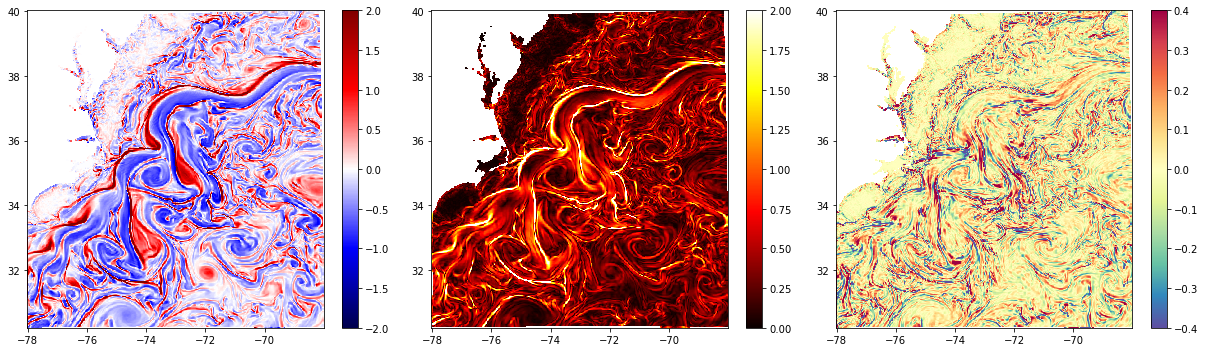

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 orca01w.nav_lat.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 (vororcaw.isel(time_counter=0)
                  / orcaf.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
                 ).isel(y=slice(None,450)), 
                 cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 orca01w.nav_lat.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 (strorcaw.isel(time_counter=0)
                  / orcaf.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
                 ).isel(y=slice(None,450)), 
                 cmap='hot', vmin=0, vmax=2, rasterized=True)
im3 = ax3.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 orca01w.nav_lat.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 (divorcaw.isel(time_counter=0)
                  / orcaf.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
                 ).isel(y=slice(None,450)), 
                 cmap='Spectral_r', vmax=.4, vmin=-.4, rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

/tmp/ipykernel_994/1865399758.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.).isel(y=slice(None,450)),
/tmp/ipykernel_994/1865399758.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)),


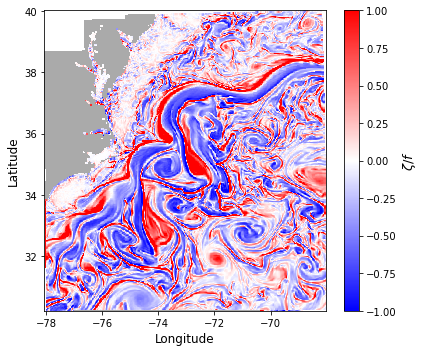

In [25]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.).isel(y=slice(None,450)), 
          orca01w.nav_lat.where(orca01w.nav_lat>0.).isel(y=slice(None,450)),
          np.ma.masked_invalid(vororcaw.isel(time_counter=0,y=slice(None,450))).mask, 
          cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolor(orca01w.nav_lon.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
               orca01w.nav_lat.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
               np.ma.masked_invalid((vororcaw.isel(time_counter=0)
                / orcaf.where(orca01_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
               ).isel(y=slice(None,450))),
               cmap='bwr', vmax=1., vmin=-1., rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-ORCA36_01.pdf')

In [26]:
gigatl01w = gigatl01w.isel(time=np.arange(0,2280,12)).chunk({'xi_u':200,'eta_rho':200,
                                                             'xi_rho':200,'eta_v':200})
gridg = gigatl01w.attrs["xgcm-Grid"]

mask_rho = gigatl01w.salt.where(gigatl01w.salt==0.).isel(time=0)
mask_u = gridg.interp(mask_rho, 'xi')
mask_v = gridg.interp(mask_rho, 'eta')
mask_psi = gridg.interp(gridg.interp(mask_rho, 'eta'), 'xi')
gigaf = gridg.interp(gridg.interp(gigatl01w.f, 'eta'), 'xi')


pm_psi = gridg.interp(gridg.interp(gigatl01w.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
pn_psi = gridg.interp(gridg.interp(gigatl01w.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigatl01w.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl01w.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl01w.pm
dvdx = gridg.diff(gigatl01w.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl01w.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl01w.pn

# gigaf.plot()
# mask_psi = gridg.interp(gridg.interp(gigatl01w.mask_rho, 'eta'), 'xi') # at psi points (eta_v, xi_u) 

vorgigaw = (dvdx - dudy).rename('vort')
strgigaw = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') 
                   + (dudy + dvdx)**2).rename('strain')
divgigaw = (dudx + dvdy).rename('div')
strgigaw

<xarray.DataArray 'strain' (time: 190, eta_v: 1488, xi_u: 1490)>
dask.array<sqrt, shape=(190, 1488, 1490), dtype=float32, chunksize=(2, 197, 197), chunktype=numpy.ndarray>
Dimensions without coordinates: time, eta_v, xi_u

In [27]:
gigatl01s = gigatl01s.isel(time=np.arange(0,2280,12)).chunk({'xi_u':200,'eta_rho':200,
                                                             'xi_rho':200,'eta_v':200})
gridg = gigatl01s.attrs["xgcm-Grid"]


# pm_psi = gridg.interp(gridg.interp(gigatl01s.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
# pn_psi = gridg.interp(gridg.interp(gigatl01s.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigatl01s.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl01s.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl01s.pm
dvdx = gridg.diff(gigatl01s.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl01s.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl01s.pn

# f_psi = gridg.interp(gridg.interp(gigatl01s.f, 'eta'), 'xi')
# mask_psi = gridg.interp(gridg.interp(gigatl01s.mask_rho, 'eta'), 'xi') # at psi points (eta_v, xi_u) 

vorgigas = (dvdx - dudy).rename('vort')
strgigas = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') 
                   + (dudy + dvdx)**2).rename('strain')
divgigas = (dudx + dvdy).rename('div')
divgigas

<xarray.DataArray 'div' (time: 190, eta_rho: 1489, xi_rho: 1491)>
dask.array<add, shape=(190, 1489, 1491), dtype=float32, chunksize=(2, 198, 198), chunktype=numpy.ndarray>
Coordinates:
    lat      (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon      (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
Dimensions without coordinates: time, eta_rho, xi_rho

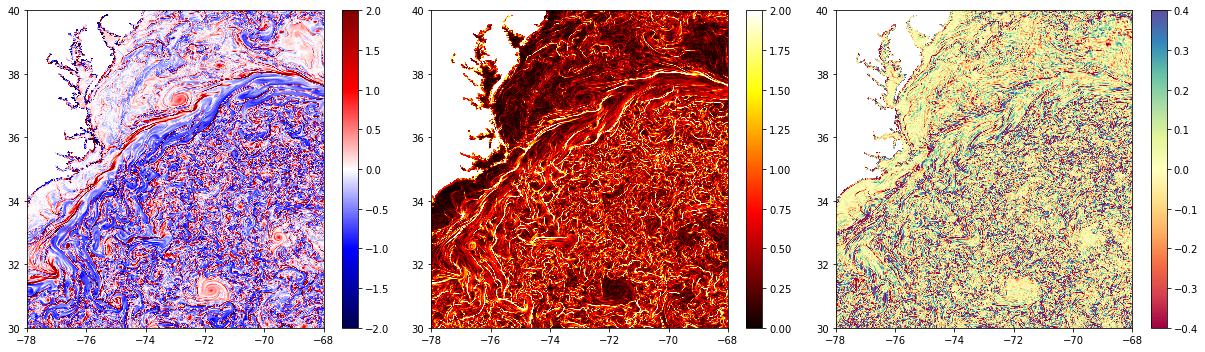

In [48]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat, vorgigaw.isel(time=0)/gigaf,
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(gigatl01w.lon, gigatl01w.lat, strgigaw.isel(time=0)/gigaf, 
                     cmap='hot', vmax=2, vmin=0., rasterized=True)
im3 = ax3.pcolormesh(gigatl01w.lon, gigatl01w.lat, 
                     gridg.interp(gridg.interp(divgigaw.isel(time=0),'xi'),'eta')/gigaf, 
                     cmap='Spectral', vmax=.4, vmin=-.4, rasterized=True)

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])
ax3.set_xlim([-78,-68])
ax3.set_ylim([30,40])

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

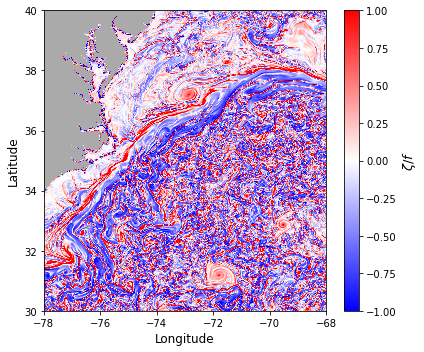

In [27]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(gigatl01w.lon, gigatl01w.lat, np.ma.masked_invalid(vorgigaw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(gigatl01w.lon, gigatl01w.lat, vorgigaw.isel(time=0)/gigaf, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-GIGATL_01.pdf')

In [16]:
vorllcw = ((gridllc.diff(llc01w.V * llc01w.dyC,'X',boundary='extend') 
            - gridllc.diff(llc01w.U * llc01w.dxC,'Y',boundary='extend')
           ) / llc01w.rAz
          ).reset_coords(drop=True).compute().chunk({'j_g':200,'i_g':200}).rename('vort')
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = vorllcw.to_dataset(name='vort')
dsave.vort.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

Exception: 503, message='Service Unavailable', url=URL('https://data.nas.nasa.gov/ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000540864/V.0000540864.data.shrunk')

In [ ]:
divllcw = ((gridllc.diff(llc01w.V * llc01w.dxG,'Y',boundary='extend') 
            + gridllc.diff(llc01w.U * llc01w.dyG,'X',boundary='extend')
           ) / llc01w.rA
          ).isel(k=0).reset_coords(drop=True).compute().chunk({'time':10,'j':200,'i':200}).rename('div')
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Div_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = divllcw.to_dataset(name='div')
dsave.div.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

In [ ]:
strllcw = np.sqrt(gridllc.interp(gridllc.interp(((gridllc.diff(llc01w.U * llc01w.dyG,
                                                               'X',boundary='extend') 
                                                  - gridllc.diff(llc01w.V * llc01w.dxG,
                                                                 'Y',boundary='extend')
                                                 ) / llc01w.rA).isel(k=0)**2 ,
                                                'Y',boundary='fill'),
                                 'X',boundary='fill')
                  + ((gridllc.diff(llc01w.U * llc01w.dxC,'Y',boundary='extend') 
                      + gridllc.diff(llc01w.V * llc01w.dyC,'X',boundary='extend') 
                     ) / llc01w.rAz).isel(k=0)**2
                 ).reset_coords(drop=True).compute().chunk({'time':10,'j_g':200,'i_g':200}).rename('strain')
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Str_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = strllcw.to_dataset(name='strain')
dsave.strain.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

In [ ]:
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-str-div_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = vorllcw.to_dataset(name='vort')
dsave['strain'] = strllcw
dsave['div'] = divllcw
dsave.vort.encoding = {}
dsave.strain.encoding = {}
dsave.div.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

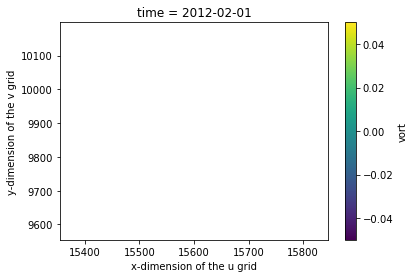

In [11]:
vorllcw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-str-div_fma.zarr")).vort
# vorllcw = xr.open_zarr(gcs.get_mapper(f'{SCRATCH}/region01/LLC4320/'+f'Vort_fma.zarr')).vort
# divllcw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Div_fma.zarr")).div
# strllcw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Str_fma.zarr")).strain
vorllcw.isel(time=0).plot()

In [29]:
vorllcs = ((gridllc.diff(llc01s.V[::12] * llc01s.dyC,'X',boundary='extend') 
            - gridllc.diff(llc01s.U[::12] * llc01s.dxC,'Y',boundary='extend')
           ) / llc01s.rAz).isel(k=0).rename('vort')
divllcs = ((gridllc.diff(llc01s.V[::12] * llc01s.dxG,'Y',boundary='extend') 
            + gridllc.diff(llc01s.U[::12] * llc01s.dyG,'X',boundary='extend')
           ) / llc01s.rA).isel(k=0).rename('div')
strllcs = np.sqrt(gridllc.interp(gridllc.interp(((gridllc.diff(llc01s.U[::12] * llc01s.dyG,
                                                               'X',boundary='extend') 
                                                  - gridllc.diff(llc01s.V[::12] * llc01s.dxG,
                                                                 'Y',boundary='extend')
                                                 ) / llc01s.rA)**2 ,
                                                'Y',boundary='fill'),
                                 'X',boundary='fill').isel(k=0) 
                  + ((gridllc.diff(llc01s.U[::12] * llc01s.dxC,'Y',boundary='extend') 
                      + gridllc.diff(llc01s.V[::12] * llc01s.dyC,'X',boundary='extend') 
                     ) / llc01s.rAz).isel(k=0)**2
                 ).rename('strain')

# vorllcs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-str-div_aso.zarr")).vort
# divllcs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-str-div_aso.zarr")).div
# strllcs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-str-div_aso.zarr")).strain
divllcs

<xarray.DataArray 'div' (time: 184, j: 321, i: 242)>
dask.array<open_dataset-f0427c449abf176c41cfffbdbea6e8f6div, shape=(184, 321, 242), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 7679 7680 7681 7682 7683 ... 7916 7917 7918 7919 7920
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * time     (time) datetime64[ns] 2011-08-01 ... 2011-10-31T12:00:00

In [66]:
# tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-str-div_aso.zarr'
# print(tmp_path)
# store_tmp = gcs.get_mapper(tmp_path)
# dsave = vorllcs.to_dataset(name='vort')
# dsave['strain'] = strllcs
# dsave['div'] = divllcs
# dsave.reset_coords(drop=True).chunk({'j_g':100,'j':100,
#                                      'i_g':100,'i':100}).to_zarr(store_tmp, mode='w')
# dsave.close()

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-str-div_aso.zarr


/tmp/ipykernel_1938/2912224617.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(llc01w.XG, llc01w.YG, vorllcw.isel(time=0)/llcfG, cmap='seismic', vmax=2, vmin=-2)
/tmp/ipykernel_1938/2912224617.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(llc01w.XG, llc01w.YG, strllcw.isel(time=0)/llcfG, cmap='hot', vmax=2, vmin=0.)
/tmp/ipykernel_1938/2912224617.py:6: MatplotlibDeprecationWarning: shading='flat' when X and

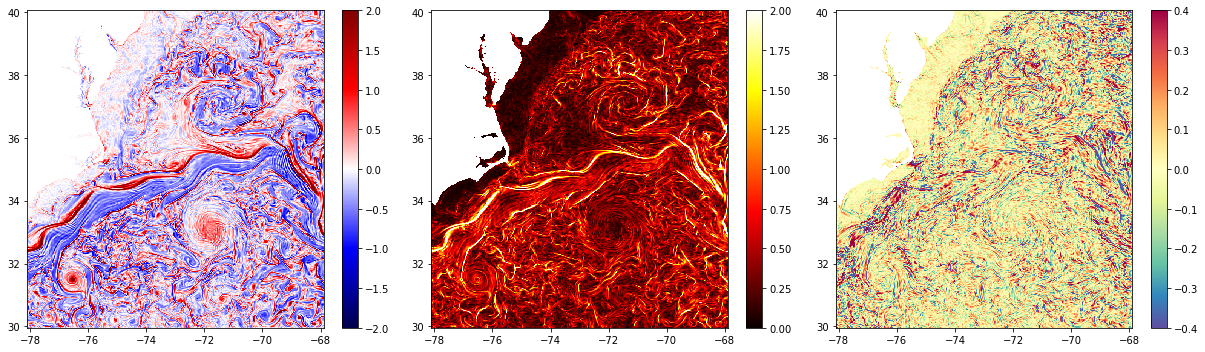

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(llc01w.XG, llc01w.YG, vorllcw.isel(time=0)/llcfG, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(llc01w.XG, llc01w.YG, strllcw.isel(time=0)/llcfG, cmap='hot', vmax=2, vmin=0.)
im3 = ax3.pcolormesh(llc01w.XG, llc01w.YG, 
                     gridllc.interp(gridllc.interp(divllcw.isel(time=0),'Y',boundary='extend'),
                                    'X',boundary='extend')/llcfG, 
                     cmap='Spectral_r', vmax=.4, vmin=-.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

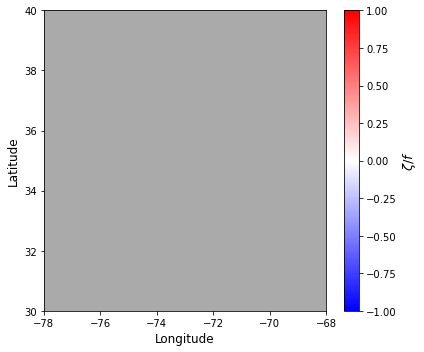

In [31]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(llc01w.XG, llc01w.YG, np.ma.masked_invalid(vorllcw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True, shading='auto')
im = ax.pcolormesh(llc01w.XG, llc01w.YG, vorllcw.isel(time=0)/llcfG, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True, shading='auto')

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-LLC4320_01.pdf')

In [33]:
Ny = len(hycom50_grid.lat)
Nx = len(hycom50_grid.lon)
import gsw
xx, yy = np.meshgrid(hycom50_grid.longitude, hycom50_grid.latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycom01w.coords['dx'] = (('lat','lon'), dx.data)
hycom01w.coords['dy'] = (('lat','lon'), dy.data)

hycom01s.coords['dx'] = (('lat','lon'), dx.data)
hycom01s.coords['dy'] = (('lat','lon'), dy.data)
hycom01s

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503, time: 2208)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2201 2202 2203 2204 2205 2206 2207
    dx         (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dy         (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>

In [34]:
hycomf = xr.apply_ufunc(gsw.f, hycom01w.latitude, dask='parallelized')
hycomf

<xarray.DataArray 'latitude' (lat: 615)>
dask.array<transpose, shape=(615,), dtype=float64, chunksize=(615,), chunktype=numpy.ndarray>
Dimensions without coordinates: lat

In [35]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def t_vort(u, v, dx, dy):
    return (
        diff(v * dy, 1, axis=-1)
        - diff(u * dx, 1, axis=-2)
    ) / (dx * dy)

def t_div(u, v, dx, dy):
    return (
        diff(v * dx, 1, axis=-2)
        + diff(u * dy, 1, axis=-1)
    ) / (dx * dy)

def t_str(u, v, dx, dy):
    str1 = (diff(u * dy, 1, axis=-1)
            - diff(v * dx, 1, axis=-2)
           ) / (dy * dx)
    str2 = (diff(u * dx, 1, axis=-2)
            + diff(v * dy, 1, axis=-1)
           ) / (dy * dx)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [36]:
vorhycomw = xr.apply_ufunc(
    t_vort,
    hycom01w.uu1[::12], 
    hycom01w.vv1[::12], 
    hycom01w.dx, hycom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divhycomw = xr.apply_ufunc(
    t_div,
    hycom01w.uu1[::12], 
    hycom01w.vv1[::12], 
    hycom01w.dx, hycom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')
strhycomw = xr.apply_ufunc(
    t_str,
    hycom01w.uu1[::12], 
    hycom01w.vv1[::12], 
    hycom01w.dx, hycom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
divhycomw

<xarray.DataArray 'div' (time: 180, lat: 615, lon: 503)>
dask.array<transpose, shape=(180, 615, 503), dtype=float32, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2088 2100 2112 2124 2136 2148
Dimensions without coordinates: lat, lon

In [41]:
vorhycoms = xr.apply_ufunc(
    t_vort,
    hycom01s.uu1[::12], 
    hycom01s.vv1[::12], 
    hycom01s.dx, hycom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divhycoms = xr.apply_ufunc(
    t_div,
    hycom01s.uu1[::12], 
    hycom01s.vv1[::12], 
    hycom01s.dx, hycom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')
strhycoms = xr.apply_ufunc(
    t_str,
    hycom01s.uu1[::12], 
    hycom01s.vv1[::12], 
    hycom01s.dx, hycom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strhycoms

<xarray.DataArray 'strain' (time: 184, lat: 615, lon: 503)>
dask.array<transpose, shape=(184, 615, 503), dtype=float32, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2136 2148 2160 2172 2184 2196
Dimensions without coordinates: lat, lon

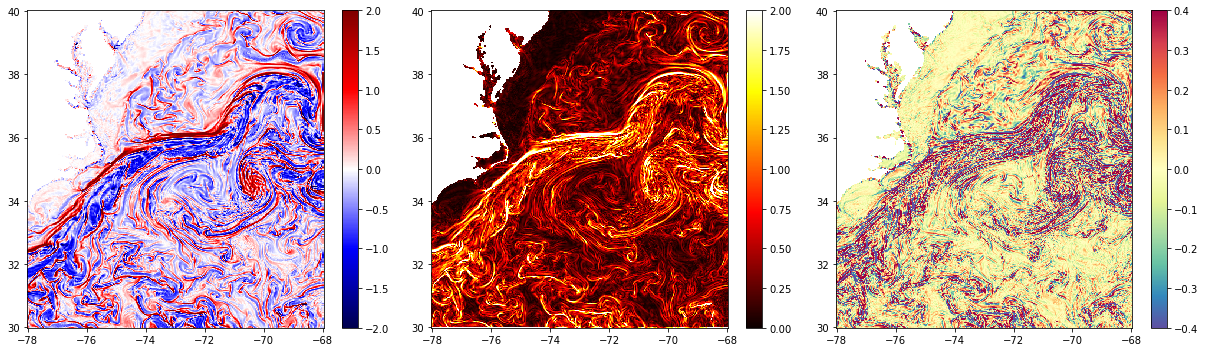

In [56]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     vorhycomw.isel(time=0)/hycomf, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     strhycomw.isel(time=0)/hycomf, cmap='hot', vmin=0., vmax=2)
im3 = ax3.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     divhycomw.isel(time=0)/hycomf, cmap='Spectral_r', vmin=-.4, vmax=.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

/tmp/ipykernel_994/3222145035.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude,
/tmp/ipykernel_994/3222145035.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude,


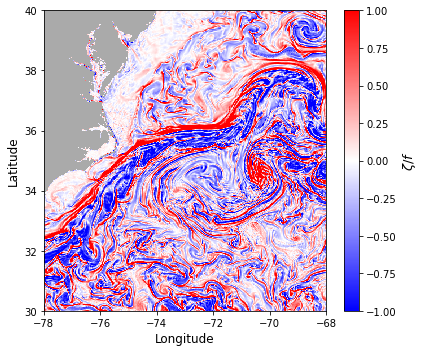

In [39]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude, 
              np.ma.masked_invalid(vorhycomw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude, 
                   vorhycomw.isel(time=0)/hycomf, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-HYCOM50_01.pdf')

In [40]:
Ny = len(fesom01s.lat)
Nx = len(fesom01s.lon)
import gsw
xx, yy = np.meshgrid(fesom01s.lon, fesom01s.lat)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

fesom01w.coords['dx'] = (('lat','lon'), dx.data)
fesom01w.coords['dy'] = (('lat','lon'), dy.data)

fesom01s.coords['dx'] = (('lat','lon'), dx.data)
fesom01s.coords['dy'] = (('lat','lon'), dy.data)
fesom01s

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-08-01 ... 2012-10-31T23:00:00
    dx       (lat, lon) float64 963.9 963.9 963.9 963.9 ... 852.7 852.7 852.7
    dy       (lat, lon) float64 1.113e+03 1.113e+03 ... 1.113e+03 1.113e+03
Data variables:
    dflux    (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ssh      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sss      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    tx_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ty_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    u_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    v_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>

In [41]:
fesomf = xr.apply_ufunc(gsw.f, fesom01w.lat, dask='parallelized')
fesomf

<xarray.DataArray 'lat' (lat: 1000)>
array([7.29211500e-05, 7.29432150e-05, 7.29652778e-05, 7.29873383e-05,
       7.30093967e-05, 7.30314528e-05, 7.30535066e-05, 7.30755583e-05,
       7.30976077e-05, 7.31196549e-05, 7.31416998e-05, 7.31637425e-05,
       7.31857830e-05, 7.32078213e-05, 7.32298573e-05, 7.32518911e-05,
       7.32739226e-05, 7.32959519e-05, 7.33179790e-05, 7.33400038e-05,
       7.33620264e-05, 7.33840467e-05, 7.34060649e-05, 7.34280807e-05,
       7.34500944e-05, 7.34721057e-05, 7.34941149e-05, 7.35161218e-05,
       7.35381265e-05, 7.35601289e-05, 7.35821290e-05, 7.36041270e-05,
       7.36261226e-05, 7.36481161e-05, 7.36701073e-05, 7.36920962e-05,
       7.37140829e-05, 7.37360673e-05, 7.37580495e-05, 7.37800294e-05,
       7.38020071e-05, 7.38239825e-05, 7.38459557e-05, 7.38679266e-05,
       7.38898953e-05, 7.39118617e-05, 7.39338259e-05, 7.39557877e-05,
       7.39777474e-05, 7.39997048e-05, 7.40216599e-05, 7.40436128e-05,
       7.40655634e-05, 7.40875117e-05, 7.41094578e-05, 7.41314016e-05,
       7.41533432e-05, 7.41752825e-05, 7.41972195e-05, 7.42191543e-05,
       7.42410868e-05, 7.42630170e-05, 7.42849450e-05, 7.43068707e-05,
       7.43287941e-05, 7.43507152e-05, 7.43726341e-05, 7.43945508e-05,
       7.44164651e-05, 7.44383772e-05, 7.44602870e-05, 7.44821945e-05,
       7.45040998e-05, 7.45260028e-05, 7.45479035e-05, 7.45698020e-05,
       7.45916981e-05, 7.46135920e-05, 7.46354836e-05, 7.46573729e-05,
...
       9.21947717e-05, 9.22145132e-05, 9.22342517e-05, 9.22539875e-05,
       9.22737205e-05, 9.22934506e-05, 9.23131780e-05, 9.23329025e-05,
       9.23526242e-05, 9.23723430e-05, 9.23920591e-05, 9.24117723e-05,
       9.24314827e-05, 9.24511903e-05, 9.24708951e-05, 9.24905970e-05,
       9.25102962e-05, 9.25299925e-05, 9.25496859e-05, 9.25693766e-05,
       9.25890644e-05, 9.26087494e-05, 9.26284316e-05, 9.26481109e-05,
       9.26677874e-05, 9.26874611e-05, 9.27071320e-05, 9.27268000e-05,
       9.27464652e-05, 9.27661276e-05, 9.27857871e-05, 9.28054438e-05,
       9.28250977e-05, 9.28447487e-05, 9.28643969e-05, 9.28840423e-05,
       9.29036848e-05, 9.29233245e-05, 9.29429614e-05, 9.29625954e-05,
       9.29822266e-05, 9.30018550e-05, 9.30214805e-05, 9.30411032e-05,
       9.30607230e-05, 9.30803400e-05, 9.30999541e-05, 9.31195655e-05,
       9.31391739e-05, 9.31587795e-05, 9.31783823e-05, 9.31979823e-05,
       9.32175794e-05, 9.32371736e-05, 9.32567650e-05, 9.32763536e-05,
       9.32959393e-05, 9.33155221e-05, 9.33351021e-05, 9.33546793e-05,
       9.33742536e-05, 9.33938251e-05, 9.34133937e-05, 9.34329595e-05,
       9.34525224e-05, 9.34720824e-05, 9.34916396e-05, 9.35111940e-05,
       9.35307455e-05, 9.35502941e-05, 9.35698399e-05, 9.35893828e-05,
       9.36089229e-05, 9.36284601e-05, 9.36479945e-05, 9.36675260e-05,
       9.36870546e-05, 9.37065804e-05, 9.37261033e-05, 9.37456234e-05])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0

In [42]:
vorfesomw = xr.apply_ufunc(
    t_vort,
    fesom01w.u_surf[::12], 
    fesom01w.v_surf[::12], 
    fesom01w.dx, fesom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01w.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divfesomw = xr.apply_ufunc(
    t_div,
    fesom01w.u_surf[::12], 
    fesom01w.v_surf[::12], 
    fesom01w.dx, fesom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01w.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')
strfesomw = xr.apply_ufunc(
    t_str,
    fesom01w.u_surf[::12], 
    fesom01w.v_surf[::12], 
    fesom01w.dx, fesom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01w.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
divfesomw

<xarray.DataArray 'div' (time: 180, lat: 1000, lon: 1000)>
dask.array<transpose, shape=(180, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T12:00:00

In [45]:
vorfesoms = xr.apply_ufunc(
    t_vort,
    fesom01s.u_surf[::12], 
    fesom01s.v_surf[::12], 
    fesom01s.dx, fesom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01s.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divfesoms = xr.apply_ufunc(
    t_div,
    fesom01s.u_surf[::12], 
    fesom01s.v_surf[::12], 
    fesom01s.dx, fesom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01s.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')
strfesoms = xr.apply_ufunc(
    t_str,
    fesom01s.u_surf[::12], 
    fesom01s.v_surf[::12], 
    fesom01s.dx, fesom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01s.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
divfesoms

<xarray.DataArray 'div' (time: 184, lat: 1000, lon: 1000)>
dask.array<transpose, shape=(184, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-08-01 ... 2012-10-31T12:00:00

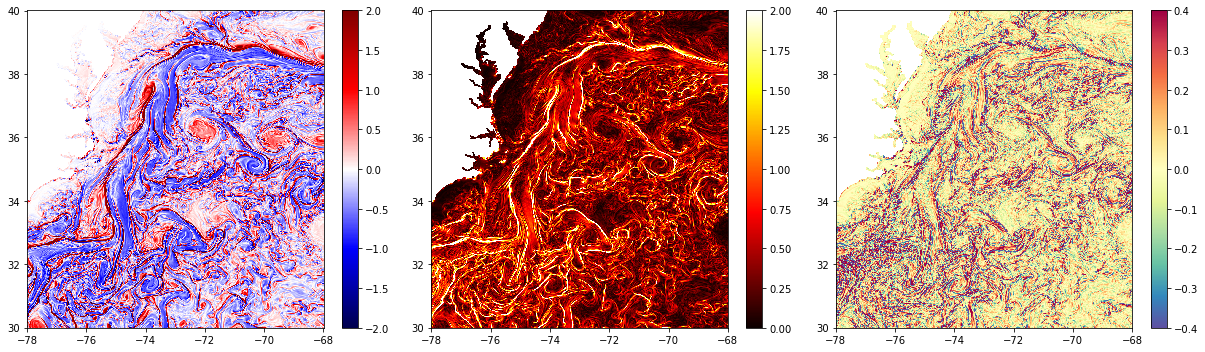

In [75]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     vorfesomw.isel(time=0)/fesomf, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     strfesomw.isel(time=0)/fesomf, cmap='hot', vmin=0., vmax=2)
im3 = ax3.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     divfesomw.isel(time=0)/fesomf, cmap='Spectral_r', vmin=-.4, vmax=.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

/tmp/ipykernel_994/697012521.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(fesom01w.lon, fesom01w.lat, np.ma.masked_invalid(vorfesomw.isel(time=0)).mask,
/tmp/ipykernel_994/697012521.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(fesom01w.lon, fesom01w.lat, vorfesomw.isel(time=0)/fesomf,


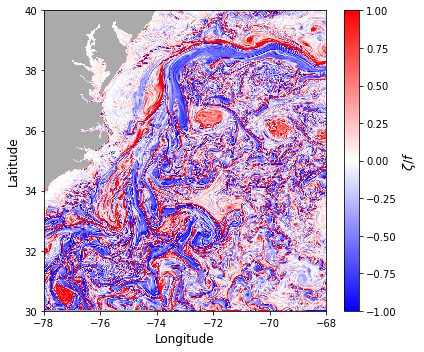

In [43]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(fesom01w.lon, fesom01w.lat, np.ma.masked_invalid(vorfesomw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(fesom01w.lon, fesom01w.lat, vorfesomw.isel(time=0)/fesomf, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-FESOM_01.pdf')

In [ ]:
vorfiow = ((gridllc.diff(llc01w.V * llc01w.dyC,'X',boundary='extend') 
             - gridllc.diff(llc01w.U * llc01w.dxC,'Y',boundary='extend')
            ) / llc01w.rAz
          ).isel(k=0).reset_coords(drop=True).compute().chunk({'j_g':200,'i_g':200}).rename('vort')

In [31]:
vbins = np.linspace(-4e0,4e0,40)
sbins = np.linspace(0,4e0,20)

In [32]:
histenatlw = xhist((strenatlw/enatlf).rename('strain').isel(y=slice(2,-2),
                                                            x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vorenatlw/enatlf).rename('vort').isel(y=slice(2,-2),
                                                          x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histenatls = xhist((strenatls/enatlf).rename('strain').isel(y=slice(2,-2),
                                                            x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vorenatls/enatlf).rename('vort').isel(y=slice(2,-2),
                                                          x=slice(2,-2)).chunk({'y':-1,'x':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [33]:
historcaw = xhist((strorcaw/orcaf).rename('strain').isel(y=slice(2,450),
                                                         x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vororcaw/orcaf).rename('vort').isel(y=slice(2,450),
                                                        x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
historcas = xhist((strorcas/orcaf).rename('strain').isel(y=slice(2,450),
                                                         x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vororcas/orcaf).rename('vort').isel(y=slice(2,450),
                                                        x=slice(2,-2)).chunk({'y':-1,'x':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [34]:
histgigatlw = xhist((strgigaw/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                           xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    (vorgigaw/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                         xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    bins=[sbins, vbins]
                   ).compute()
histgigatls = xhist((strgigas/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                           xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    (vorgigas/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                         xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),  
                    bins=[sbins, vbins]
                   ).compute()

In [46]:
histhycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histhycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [47]:
histfesomw = xhist((strfesomw/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorfesomw/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histfesoms = xhist((strfesoms/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorfesoms/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [48]:
histllcw = xhist((strllcw/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 bins=[sbins, vbins]
                ).compute()
histllcs = xhist((strllcs/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),
                 (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),  
                 bins=[sbins, vbins]
                ).compute()

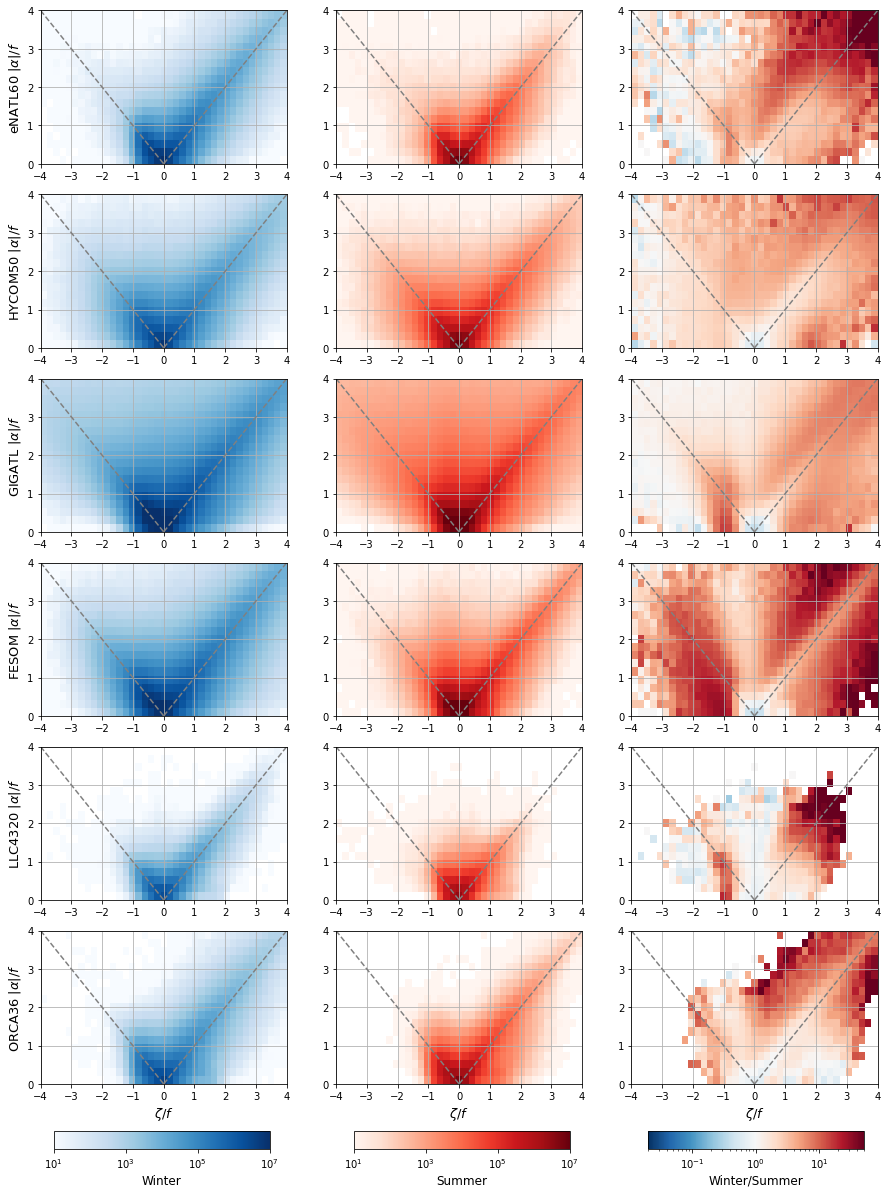

In [55]:
fig, axes = plt.subplots(figsize=(15,21), nrows=6, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]
ax40 = axes[4,0]
ax41 = axes[4,1]
ax42 = axes[4,2]
ax50 = axes[5,0]
ax51 = axes[5,1]
ax52 = axes[5,2]


im0 = ax00.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin,
                      histenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                      rasterized=True, shading='auto')
ax10.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin,
                histhycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax20.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin,
                histgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax30.pcolormesh(histfesomw.vort_bin,
                histfesomw.strain_bin,
                histfesomw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax40.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin,
                histllcw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax50.pcolormesh(historcaw.vort_bin,
                historcaw.strain_bin,
                historcaw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')

im1 = ax01.pcolormesh(histenatls.vort_bin,
                      histenatls.strain_bin,
                      histenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                      rasterized=True, shading='auto')
ax11.pcolormesh(histhycoms.vort_bin,
                histhycoms.strain_bin,
                histhycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax21.pcolormesh(histgigatls.vort_bin,
                histgigatls.strain_bin,
                histgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax31.pcolormesh(histfesoms.vort_bin,
                histfesoms.strain_bin,
                histfesoms,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax41.pcolormesh(histllcs.vort_bin,
                histllcs.strain_bin,
                histllcs,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax51.pcolormesh(historcas.vort_bin,
                historcas.strain_bin,
                historcas,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')

im2 = ax02.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin, 
                      (histenatlw
                       / histenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True, shading='auto')
ax12.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin, 
                (histhycomw
                 / histhycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax22.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin, 
                (histgigatlw
                 / histgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax32.pcolormesh(histfesomw.vort_bin,
                histfesomw.strain_bin, 
                (histfesomw
                 / histfesoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax42.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin, 
                (histllcw
                 / histllcs), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax52.pcolormesh(historcaw.vort_bin,
                historcaw.strain_bin, 
                (historcaw
                 / historcas), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')


ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax40.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax40.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax41.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax41.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax42.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax42.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax50.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax50.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax51.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax51.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax52.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax52.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax40.set_xlim([-4,4])
ax41.set_xlim([-4,4])
ax42.set_xlim([-4,4])
ax50.set_xlim([-4,4])
ax51.set_xlim([-4,4])
ax52.set_xlim([-4,4])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])
ax40.set_ylim([0,4])
ax41.set_ylim([0,4])
ax42.set_ylim([0,4])
ax50.set_ylim([0,4])
ax51.set_ylim([0,4])
ax52.set_ylim([0,4])

ax50.set_xlabel(r"$\zeta/f$", fontsize=13)
ax51.set_xlabel(r"$\zeta/f$", fontsize=13)
ax52.set_xlabel(r"$\zeta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=13)
ax30.set_ylabel(r"FESOM $|\alpha|/f$", fontsize=13)
ax40.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=13)
ax50.set_ylabel(r"ORCA36 $|\alpha|/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)
ax40.grid(True)
ax41.grid(True)
ax42.grid(True)
ax50.grid(True)
ax51.grid(True)
ax52.grid(True)

fig.subplots_adjust(bottom=.17, hspace=.2) 
cbax0 = fig.add_axes([0.137, 0.127, 0.2, 0.012])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.127, 0.2, 0.012])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.687, 0.127, 0.2, 0.012])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/vort-strain-jointPDF_01.pdf')

In [37]:
dbins = np.linspace(-1e0,1e0,40)

In [38]:
dhistenatlw = xhist((t_to_f(divenatlw)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    (vorenatlw/enatlf).rename('vort').isel(y=slice(2,-2),
                                                           x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[dbins, vbins]
                   ).compute()
dhistenatls = xhist((t_to_f(divenatls)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),  
                    (vorenatls/enatlf).rename('vort').isel(y=slice(2,-2),
                                                           x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[dbins, vbins]
                   ).compute()

In [39]:
dhistgigatlw = xhist((gridg.interp(gridg.interp(divgigaw,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (vorgigaw/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                          xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[dbins, vbins]
                    ).compute()
dhistgigatls = xhist((gridg.interp(gridg.interp(divgigas,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),  
                     (vorgigas/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                          xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[dbins, vbins]
                    ).compute()

In [40]:
dhisthycomw = xhist((t_to_f(divhycomw)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                           lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[dbins, vbins]
                   ).compute()
dhisthycoms = xhist((t_to_f(divhycoms)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                    (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                           lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[dbins, vbins]
                   ).compute()

In [ ]:
dhistllcw = xhist((gridllc.interp(gridllc.interp(divllcw,'X',boundary='extend'),'Y',boundary='extend')
                   / llcfG).rename('div').isel(j_g=slice(2,-2),
                                               i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                      i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  bins=[dbins, vbins]
                 ).compute()
dhistllcs = xhist((gridllc.interp(gridllc.interp(divllcs,'X',boundary='extend'),'Y',boundary='extend')
                   / llcfG).rename('div').isel(j_g=slice(2,-2),
                                               i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                      i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  bins=[dbins, vbins]
                 ).compute()

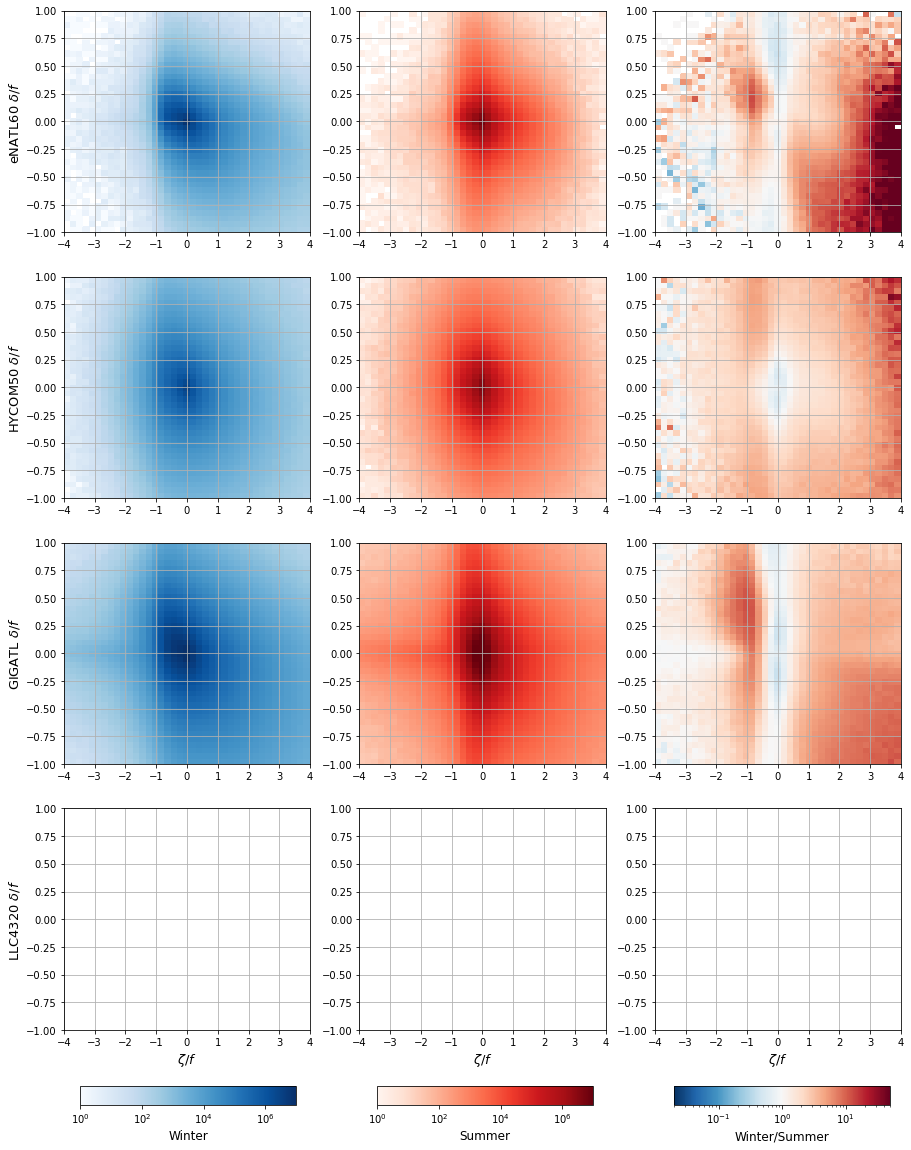

In [42]:
fig, axes = plt.subplots(figsize=(15,20), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(dhistenatlw.vort_bin,
                      dhistenatlw.div_bin,
                      dhistenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax10.pcolormesh(dhisthycomw.vort_bin,
                dhisthycomw.div_bin,
                dhisthycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax20.pcolormesh(dhistgigatlw.vort_bin,
                dhistgigatlw.div_bin,
                dhistgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax30.pcolormesh(dhistllcw.vort_bin,
#                 dhistllcw.div_bin,
#                 dhistllcw,
#                 cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im1 = ax01.pcolormesh(dhistenatls.vort_bin,
                      dhistenatls.div_bin,
                      dhistenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax11.pcolormesh(dhisthycoms.vort_bin,
                dhisthycoms.div_bin,
                dhisthycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax21.pcolormesh(dhistgigatls.vort_bin,
                dhistgigatls.div_bin,
                dhistgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax31.pcolormesh(histllcs.vort_bin,
#                 histllcs.div_bin,
#                 histllcs,  
#                 cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im2 = ax02.pcolormesh(dhistenatlw.vort_bin,
                      dhistenatlw.div_bin, 
                      (dhistenatlw
                       / dhistenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True)
ax12.pcolormesh(dhisthycomw.vort_bin,
                dhisthycomw.div_bin, 
                (dhisthycomw
                 / dhisthycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
ax22.pcolormesh(dhistgigatlw.vort_bin,
                dhistgigatlw.div_bin, 
                (dhistgigatlw
                 / dhistgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
# ax32.pcolormesh(histllcw.vort_bin,
#                 histllcw.div_bin, 
#                 (histllcw
#                  / histllcs), 
#                 cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
#                 rasterized=True)


# ax00.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax01.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax02.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax10.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax11.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax12.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax20.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax21.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax22.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax30.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax31.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax32.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax00.set_ylim([-1,1])
ax01.set_ylim([-1,1])
ax02.set_ylim([-1,1])
ax10.set_ylim([-1,1])
ax11.set_ylim([-1,1])
ax12.set_ylim([-1,1])
ax20.set_ylim([-1,1])
ax21.set_ylim([-1,1])
ax22.set_ylim([-1,1])
ax30.set_ylim([-1,1])
ax31.set_ylim([-1,1])
ax32.set_ylim([-1,1])

ax30.set_xlabel(r"$\zeta/f$", fontsize=13)
ax31.set_xlabel(r"$\zeta/f$", fontsize=13)
ax32.set_xlabel(r"$\zeta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $\delta/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $\delta/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $\delta/f$", fontsize=13)
ax30.set_ylabel(r"LLC4320 $\delta/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/vort-div-jointPDF_01.pdf')

In [47]:
shistenatlw = xhist((strenatlw/enatlf).rename('strain').isel(y=slice(2,-2),
                                                             x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    (t_to_f(divenatlw)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    bins=[sbins, dbins]
                   ).compute()
shistenatls = xhist((strenatls/enatlf).rename('strain').isel(y=slice(2,-2),
                                                             x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    (t_to_f(divenatls)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[sbins, dbins]
                   ).compute()

In [49]:
shistgigatlw = xhist((strgigaw/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                            xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (gridg.interp(gridg.interp(divgigaw,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[sbins, dbins]
                    ).compute()
shistgigatls = xhist((strgigas/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                            xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (gridg.interp(gridg.interp(divgigas,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[sbins, dbins]
                    ).compute()

In [50]:
shisthycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                             lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (t_to_f(divhycomw)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    bins=[sbins, dbins]
                   ).compute()
shisthycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                             lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (t_to_f(divhycoms)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[sbins, dbins]
                   ).compute()

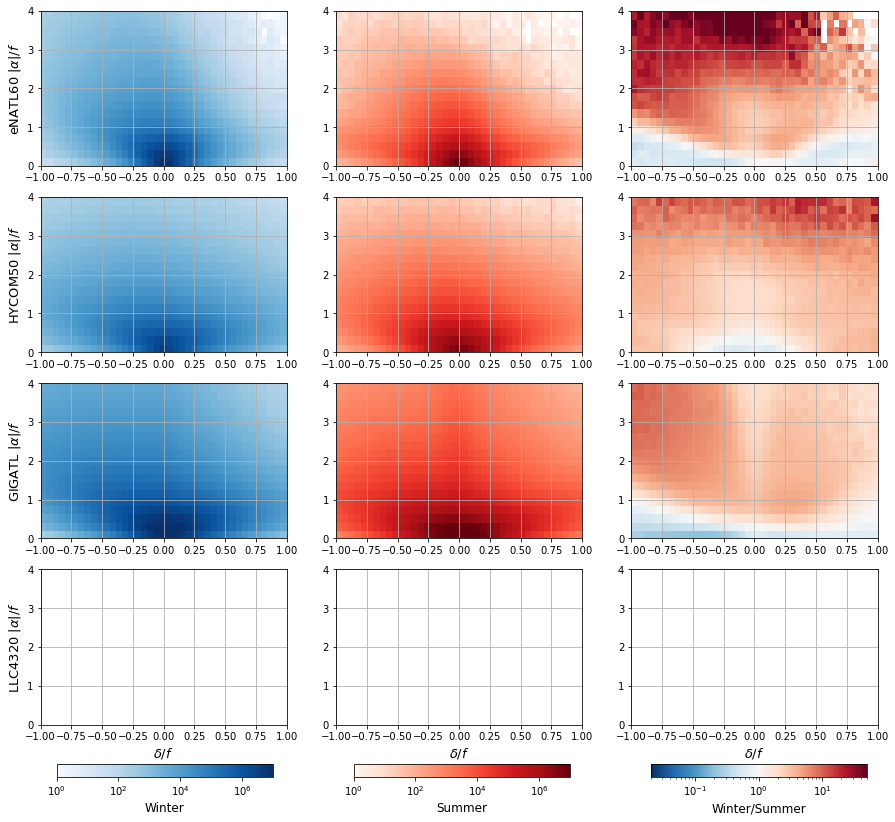

In [51]:
fig, axes = plt.subplots(figsize=(15,14), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(shistenatlw.div_bin,
                      shistenatlw.strain_bin,
                      shistenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax10.pcolormesh(shisthycomw.div_bin,
                shisthycomw.strain_bin,
                shisthycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax20.pcolormesh(shistgigatlw.div_bin,
                shistgigatlw.strain_bin,
                shistgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax30.pcolormesh(histllcw.vort_bin,
#                 histllcw.strain_bin,
#                 histllcw,
#                 cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im1 = ax01.pcolormesh(shistenatls.div_bin,
                      shistenatls.strain_bin,
                      shistenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax11.pcolormesh(shisthycoms.div_bin,
                shisthycoms.strain_bin,
                shisthycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax21.pcolormesh(shistgigatls.div_bin,
                shistgigatls.strain_bin,
                shistgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax31.pcolormesh(histllcs.vort_bin,
#                 histllcs.strain_bin,
#                 histllcs,  
#                 cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im2 = ax02.pcolormesh(shistenatlw.div_bin,
                      shistenatlw.strain_bin, 
                      (shistenatlw
                       / shistenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True)
ax12.pcolormesh(shisthycomw.div_bin,
                shisthycomw.strain_bin, 
                (shisthycomw
                 / shisthycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
ax22.pcolormesh(shistgigatlw.div_bin,
                shistgigatlw.strain_bin, 
                (shistgigatlw
                 / shistgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
# ax32.pcolormesh(histllcw.vort_bin,
#                 histllcw.strain_bin, 
#                 (histllcw
#                  / histllcs), 
#                 cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
#                 rasterized=True)


# ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-1,1])
ax01.set_xlim([-1,1])
ax02.set_xlim([-1,1])
ax10.set_xlim([-1,1])
ax11.set_xlim([-1,1])
ax12.set_xlim([-1,1])
ax20.set_xlim([-1,1])
ax21.set_xlim([-1,1])
ax22.set_xlim([-1,1])
ax30.set_xlim([-1,1])
ax31.set_xlim([-1,1])
ax32.set_xlim([-1,1])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])

ax30.set_xlabel(r"$\delta/f$", fontsize=13)
ax31.set_xlabel(r"$\delta/f$", fontsize=13)
ax32.set_xlabel(r"$\delta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=13)
ax30.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/div-strain-jointPDF_01.pdf')

In [ ]:
client.close()